In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [36]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

os.chdir('/gdrive/MyDrive/Dacon/Heart/')

In [5]:
!pip install catboost --quiet

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [53]:
from catboost import CatBoostClassifier, cv, Pool

In [7]:
dir = os.getcwd() + '/Dataset/'

train = pd.read_csv(dir + 'train.csv')
test  = pd.read_csv(dir + 'test.csv')

In [66]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']

In [48]:
numeric_features = ['age', 'chol', 'thalach', 'trestbps', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Catboost baseline

In [67]:
cb = CatBoostClassifier(verbose=False, border_count=None)

param_grid = {'iterations':[100, 200, 300],
              'depth': [2, 3, 4, 5, 6],
              'leaf_estimation_iterations': [5, 10],
              'l2_leaf_reg' : [2, 5, 10],
              'loss_function': ['MultiClass'],
              'eval_metric': ['TotalF1'],
              'random_seed': [821]}

pipe = Pipeline([
                 ('grid_search', GridSearchCV(cb, param_grid, cv=10, refit=True, scoring='f1'))
                 ])

pipe.fit(X, y)
print(pipe.score(X, y))

0.9585798816568047


In [68]:
pipe['grid_search'].best_params_

{'depth': 3,
 'eval_metric': 'TotalF1',
 'iterations': 200,
 'l2_leaf_reg': 5,
 'leaf_estimation_iterations': 5,
 'loss_function': 'MultiClass',
 'random_seed': 821}

In [69]:
pred = pipe.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        68
           1       0.94      0.98      0.96        83

    accuracy                           0.95       151
   macro avg       0.96      0.95      0.95       151
weighted avg       0.95      0.95      0.95       151



In [70]:
pred = pipe.predict(test)

In [71]:
submission = pd.read_csv(dir + 'sample_submission.csv')
submission['target'] = pred

submission.to_csv(dir + 'submission2.csv', index=False)

# RandomForest baseline

In [ ]:
clf = RandomForestClassifier()

scores = cross_val_score(clf, X, y, cv=10, scoring='f1') 

print(f'cross-val-score \n{scores}')
print(f'cross-val-score.mean \n{scores.mean():.3f}')

clf.fit(X, y)
pred = clf.predict(X)
print(classification_report(y, pred))

cross-val-score 
[0.77777778 0.84210526 0.88888889 0.875      0.82352941 0.8
 0.875      0.8        0.88888889 0.5       ]
cross-val-score.mean 
0.807
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        83

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151



# RandomForest lab

In [ ]:
model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=8)
fit = rfe.fit(X, y)

print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {fit.support_}")
print(f"Feature Ranking: {fit.ranking_}")

Num Features: 8
Selected Features: [ True False  True  True  True False False  True False  True False  True
  True]
Feature Ranking: [1 4 1 1 1 6 5 1 2 1 3 1 1]


In [ ]:
model = RandomForestClassifier(random_state=821)

param_grid = [{'max_depth': [4, 6, 8], 
               'n_estimators': [50, 100, 500], 
               'min_samples_split': [50, 100]
              }]

pipe = Pipeline([
                 ('feature_selection', RFE(estimator=model, n_features_to_select=8)),
                 ('grid_search', GridSearchCV(model, param_grid, cv=10, refit=True, scoring='f1'))
                 ])

pipe.fit(X, y)
print(f'[f1 score]\n{pipe.score(X, y)}')

[f1 score]
0.9047619047619048


In [ ]:
pipe['grid_search'].best_params_

{'max_depth': 4, 'min_samples_split': 50, 'n_estimators': 100}

In [ ]:
X.columns[pipe['feature_selection'].support_]

Index(['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal'], dtype='object')

In [ ]:
pipe['grid_search'].cv_results_['split8_test_score'].mean()

0.8184143222506395

In [ ]:
pred = pipe.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        68
           1       0.89      0.92      0.90        83

    accuracy                           0.89       151
   macro avg       0.89      0.89      0.89       151
weighted avg       0.89      0.89      0.89       151



# Voting Baseline

In [ ]:
model1 = RandomForestClassifier(random_state=821, **pipe['grid_search'].best_params_)
model2 = LogisticRegression(random_state=821)
model3 = AdaBoostClassifier(random_state=821)

            
pipe1 = Pipeline([
                 ('clf1', model1)
                 ])

pipe2 = Pipeline([
                  ('clf2', model2)
                  ])

pipe3 = Pipeline([
                  ('clf3', model3)
                  ])

pipe_vote = Pipeline([
                      ('voting', VotingClassifier(estimators=[('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft'))
                      ])

pipe_vote.fit(X, y)
print(f'[f1 score]\n{pipe_vote.score(X, y)}')

scores = cross_val_score(pipe_vote, X, y, cv=10, scoring='f1')
print(f'[all cv_scores]\n{scores}')
print(f'[mean cv_scores]\n{scores.mean()}')

[f1 score]
0.8874172185430463
[all cv_scores]
[0.9        0.84210526 0.84210526 0.77777778 0.88888889 0.94117647
 0.94117647 0.71428571 0.94117647 0.61538462]
[mean cv_scores]
0.8404076934417493


In [ ]:
pred = pipe_vote.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        68
           1       0.87      0.94      0.90        83

    accuracy                           0.89       151
   macro avg       0.89      0.88      0.88       151
weighted avg       0.89      0.89      0.89       151



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, pipe_vote.predict(X))

array([[56, 12],
       [ 5, 78]])

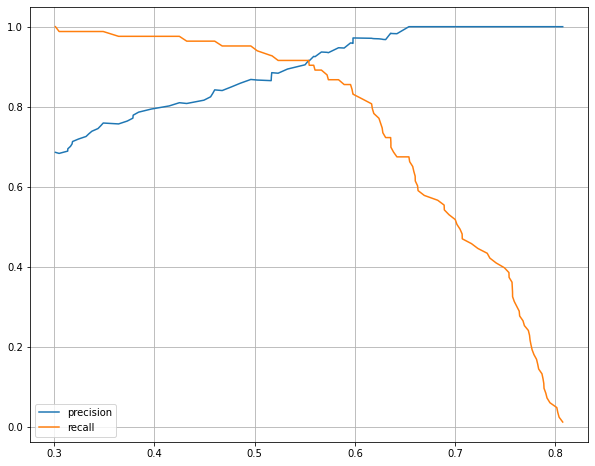

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
pred = pipe_vote.predict_proba(X)[:,1]
precision, recalls, thresholds = precision_recall_curve(y, pred)
plt.plot(thresholds, precision[:len(thresholds)], label = 'precision')
plt.plot(thresholds, recalls[:len(thresholds)], label = 'recall')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import Binarizer

pred_proba = pipe_vote.predict_proba(X)

binarizer = Binarizer(threshold=0.55).fit(pred_proba)
pred_bin = binarizer.transform(pred_proba)[:,1]
pred_bin

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])

In [ ]:
print(classification_report(y, pred_bin))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        68
           1       0.90      0.92      0.91        83

    accuracy                           0.90       151
   macro avg       0.90      0.90      0.90       151
weighted avg       0.90      0.90      0.90       151



In [ ]:
confusion_matrix(y, pred_bin)

array([[60,  8],
       [ 7, 76]])

In [ ]:
pred = pipe_vote.predict_proba(test.drop(['id'], axis=1))[:,1]
pred = np.where(pred >= 0.55 , 1, 0)

In [ ]:
pred

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
submission = pd.read_csv(dir + 'sample_submission.csv')
submission['target'] = pred

submission.to_csv(dir + 'submission1.csv', index=False)

## with Feature Selection

In [ ]:
model1 = RandomForestClassifier(random_state=821)
model2 = LogisticRegression(penalty='l2', random_state=821,)
model3 = AdaBoostClassifier(random_state=821,)

param1 = {'max_depth': [4, 6, 8],
          'n_estimators': [50, 100, 500],
          'min_samples_split': [50, 100]
          }

param2 = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [100,1000]
}

param3 = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
    }


pipe1 = Pipeline([
                 ('feature_selection', RFE(estimator=model1, n_features_to_select=8)),
                 ('clf', GridSearchCV(model1, param_grid=param1, cv=10, refit=True, n_jobs=-1, scoring='f1'))
                 ])

pipe2 = Pipeline([
                  ('feature_selection', RFE(estimator=model2, n_features_to_select=8)),
                  ('clf', GridSearchCV(model2, param_grid=param2, cv=10, refit=True, n_jobs=-1, scoring='f1'))
                  ])

pipe3 = Pipeline([
                  ('feature_selection', RFE(estimator=model3, n_features_to_select=8)),
                  ('clf', GridSearchCV(model3, param_grid=param3, cv=10, refit=True, n_jobs=-1, scoring='f1'))
                  ])

pipe_vote = Pipeline([
                      ('voting', VotingClassifier(estimators=[('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft'))
                      ])

pipe_vote.fit(X, y)
print(f'[f1 score]\n{pipe_vote.score(X, y)}')

[f1 score]
0.8940397350993378


In [ ]:
set_config(display="diagram")
pipe_vote

Pipeline(steps=[('voting',
                 VotingClassifier(estimators=[('pipe1',
                                               Pipeline(steps=[('feature_selection',
                                                                RFE(estimator=RandomForestClassifier(random_state=821),
                                                                    n_features_to_select=8)),
                                                               ('clf1',
                                                                GridSearchCV(cv=10,
                                                                             estimator=RandomForestClassifier(random_state=821),
                                                                             n_jobs=-1,
                                                                             param_grid={'max_depth': [4,
                                                                                                       6,
                                                                                                       8],
                                                                                         'min_samples_split': [50,
                                                                                                               100],
                                                                                         'n_estimators': [50,
                                                                                                          1...
                                                                                               100],
                                                                                         'max_iter': [100,
                                                                                                      1000]},
                                                                             scoring='f1'))])),
                                              ('pipe3',
                                               Pipeline(steps=[('feature_selection',
                                                                RFE(estimator=AdaBoostClassifier(random_state=821),
                                                                    n_features_to_select=8)),
                                                               ('clf3',
                                                                GridSearchCV(cv=10,
                                                                             estimator=AdaBoostClassifier(random_state=821),
                                                                             n_jobs=-1,
                                                                             param_grid={'learning_rate': [0.05,
                                                                                                           0.1],
                                                                                         'n_estimators': [100,
                                                                                                          500]},
                                                                             scoring='f1'))]))],
                                  voting='soft'))])

In [ ]:
pred = pipe_vote.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        68
           1       0.89      0.93      0.91        83

    accuracy                           0.89       151
   macro avg       0.90      0.89      0.89       151
weighted avg       0.89      0.89      0.89       151

